# Train Traffic Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
import calendar
from scipy import stats

plt.style.use('ggplot')
sns.set_context("talk")
sns.set_palette("colorblind")

In [2]:
# Load the data
with open("detections.json") as f:
    data = json.load(f)

df = pd.DataFrame(data['detections'])

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['time_decimal'] = df['hour'] + df['minute'] / 60
df['time_of_day'] = df['timestamp'].dt.strftime('%H:%M')
df['date'] = df['timestamp'].dt.date
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['week_of_year'] = df['timestamp'].dt.isocalendar().week

# Create motion intensity column
df['motion_intensity'] = df['left_motion'] + df['right_motion']

# Calculate time intervals between consecutive trains
df = df.sort_values('timestamp')
df['time_diff'] = df['timestamp'].diff()
df['minutes_since_last_train'] = df['time_diff'].dt.total_seconds() / 60

df.head()

,timestamp,left_motion,right_motion,direction,left_occupied,right_occupied,hour,minute,time_decimal,time_of_day,date,day,month,year,day_of_week,day_name,week_of_year,motion_intensity,time_diff,minutes_since_last_train
0,2025-03-01 12:42:47,1047,0,Left to Right,True,False,12,42,12.700000,12:42,2025-03-01,1,3,2025,5,Saturday,9,1047,NaT,NaN
1,2025-03-01 13:00:07,1185,0,Left to Right,True,False,13,0,13.000000,13:00,2025-03-01,1,3,2025,5,Saturday,9,1185,0 days 00:17:20,17.333333
2,2025-03-01 13:25:19,0,830,Right to Left,False,True,13,25,13.416667,13:25,2025-03-01,1,3,2025,5,Saturday,9,830,0 days 00:25:12,25.200000
3,2025-03-01 13:31:04,817,0,Left to Right,True,False,13,31,13.516667,13:31,2025-03-01,1,3,2025,5,Saturday,9,817,0 days 00:05:45,5.750000
4,2025-03-01 13:42:40,880,0,Left to Right,True,False,13,42,13.700000,13:42,2025-03-01,1,3,2025,5,Saturday,9,880,0 days 00:11:36,11.600000


# Summary Statistics

In [4]:
def format_timedelta(td):
    minutes = int(td.total_seconds() / 60)
    return f"{minutes} minutes"

In [5]:
report_data = {
    'Metric': [
        'Total Number of Trains',
        'Left to Right Trains',
        'Right to Left Trains', 
        'Time Range of Observation',
        'Busiest Hour',
        'Average Time Between Trains',
        'Most Common Direction',
        'Direction Balance Ratio',
        'Time Range with Most Activity'
    ]
}

In [6]:
direction_groups = df.groupby('direction')

In [7]:
total_trains = len(df)
ltr_trains = len(df[df['direction'] == 'Left to Right'])
rtl_trains = len(df[df['direction'] == 'Right to Left'])
time_range = f"{df['timestamp'].min().strftime('%H:%M')} - {df['timestamp'].max().strftime('%H:%M')}"
hourly_counts = df.groupby('hour').size()
busiest_hour = f"{hourly_counts.idxmax()}:00 - {hourly_counts.idxmax() + 1}:00"
avg_time_between = format_timedelta(df['time_diff'].mean())
most_common_dir = df['direction'].value_counts().index[0]
dir_balance = f"{max(ltr_trains, rtl_trains)}/{min(ltr_trains, rtl_trains)}"

In [8]:
# Split the time range into 30-minute intervals and find the busiest
df['half_hour_block'] = (df['hour'] * 2 + (df['minute'] >= 30).astype(int))
busy_block = df.groupby('half_hour_block').size().idxmax()
busy_hour = busy_block // 2
busy_minute = "30" if busy_block % 2 else "00"
next_hour = busy_hour + 1 if busy_minute == "30" else busy_hour
next_minute = "00" if busy_minute == "30" else "30"
busiest_period = f"{busy_hour}:{busy_minute} - {next_hour}:{next_minute}"

In [9]:
report_data['Value'] = [
    total_trains,
    ltr_trains,
    rtl_trains,
    time_range,
    busiest_hour,
    avg_time_between,
    most_common_dir,
    dir_balance,
    busiest_period
]

report_df = pd.DataFrame(report_data)
report_df

,Metric,Value
0,Total Number of Trains,1384
1,Left to Right Trains,721
2,Right to Left Trains,663
3,Time Range of Observation,12:42 - 15:02
4,Busiest Hour,8:00 - 9:00
5,Average Time Between Trains,35 minutes
6,Most Common Direction,Left to Right
7,Direction Balance Ratio,721/663
8,Time Range with Most Activity,8:30 - 9:00


# Time-Based Analysis

## Train Frequency by 30-Minute Intervals

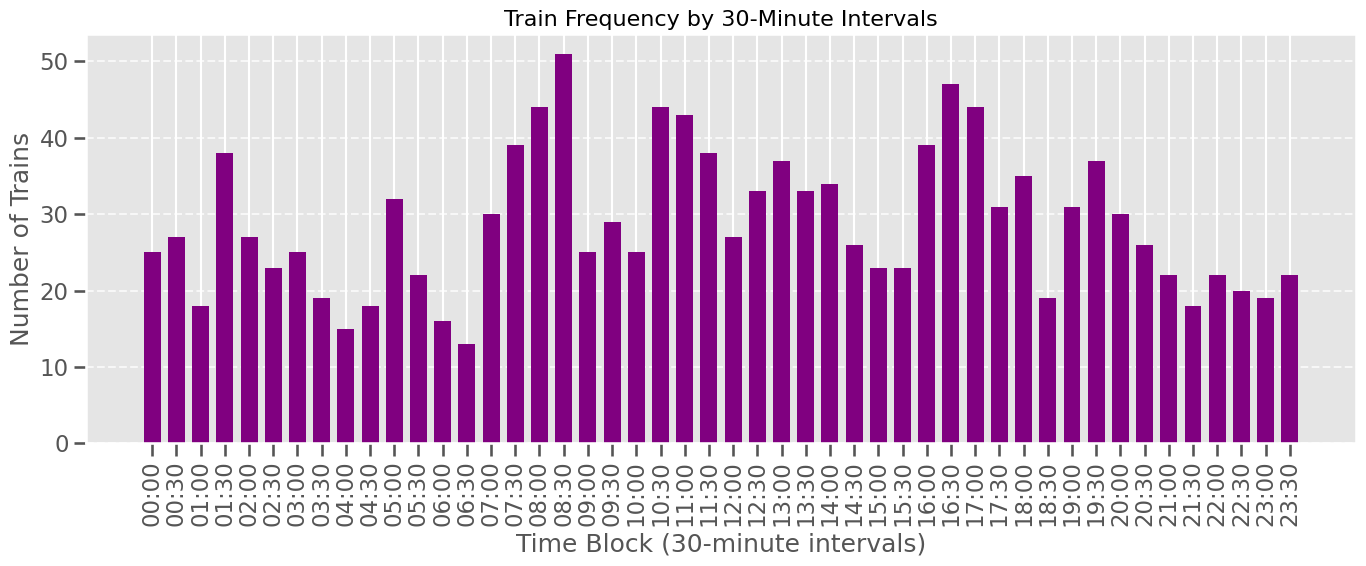

In [10]:
df['30min_block'] = (df['hour'] * 4 + (df['minute'] // 30))
time_blocks = df.groupby('30min_block').size()

# Create labels for the 30-minute blocks
labels = []
for block in time_blocks.index:
    hour = block // 4
    minute = (block % 4) * 30
    labels.append(f"{hour:02d}:{minute:02d}")

plt.figure(figsize=(14, 6))
plt.bar(labels, time_blocks.values, color='purple', width=0.7)
plt.xlabel('Time Block (30-minute intervals)')
plt.ylabel('Number of Trains')
plt.title('Train Frequency by 30-Minute Intervals', fontsize=16)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Direction Distribution

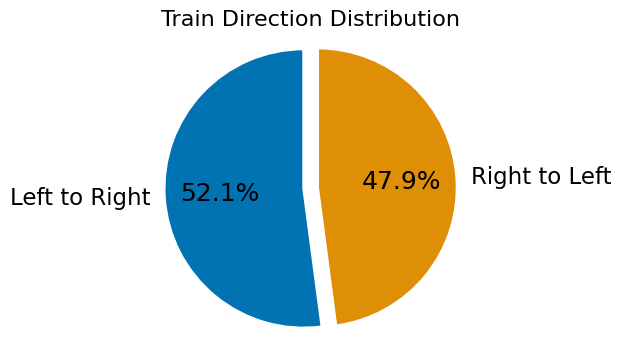

In [11]:
plt.figure(figsize=(7, 4))
direction_counts = df['direction'].value_counts()
plt.pie(direction_counts, labels=direction_counts.index, autopct='%1.1f%%', 
        startangle=90, explode=[0.05, 0.05],
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
plt.title('Train Direction Distribution', fontsize=16)
plt.axis('equal')
plt.show()

## Time Intervals Between Consecutive Trains

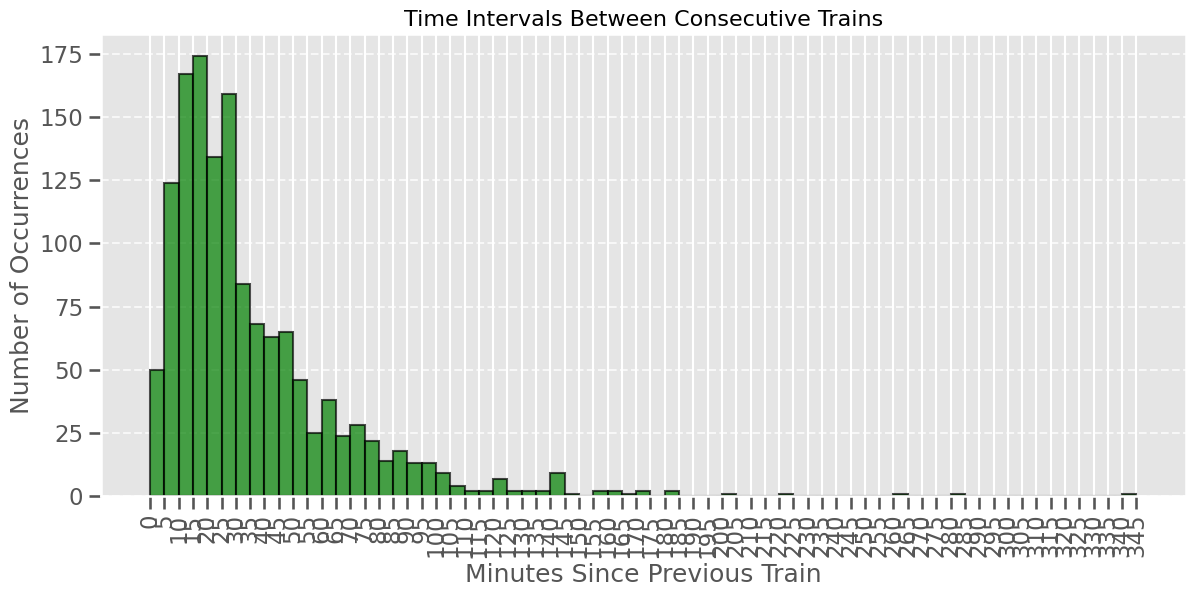

In [12]:
plt.figure(figsize=(14, 6))
intervals = df['minutes_since_last_train'].dropna()
plt.hist(intervals, bins=range(0, int(max(intervals)) + 5, 5), 
         color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Minutes Since Previous Train')
plt.ylabel('Number of Occurrences')
plt.title('Time Intervals Between Consecutive Trains', fontsize=16)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, int(max(intervals)) + 5, 5))
plt.show()

## Basic Analysis Report

In [29]:
for idx, row in report_df.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

Total Number of Trains: 1384
Left to Right Trains: 721
Right to Left Trains: 663
Time Range of Observation: 12:42 - 15:02
Busiest Hour: 8:00 - 9:00
Average Time Between Trains: 35 minutes
Most Common Direction: Left to Right
Direction Balance Ratio: 721/663
Time Range with Most Activity: 8:30 - 9:00


# Statistical Analysis

## Daily Statistics

In [14]:
daily_stats = df.groupby('date').agg(
    total_trains=('timestamp', 'count'),
    left_to_right=('direction', lambda x: (x == 'Left to Right').sum()),
    right_to_left=('direction', lambda x: (x == 'Right to Left').sum()),
    avg_interval=('minutes_since_last_train', 'mean'),
    max_interval=('minutes_since_last_train', 'max'),
    min_interval=('minutes_since_last_train', 'min'),
    avg_motion_intensity=('motion_intensity', 'mean'),
    earliest_train=('timestamp', 'min'),
    latest_train=('timestamp', 'max')
).reset_index()

daily_stats['time_span'] = (daily_stats['latest_train'] - daily_stats['earliest_train']).dt.total_seconds() / 3600
daily_stats['trains_per_hour'] = daily_stats['total_trains'] / daily_stats['time_span']
daily_stats['direction_ratio'] = daily_stats['left_to_right'] / daily_stats['right_to_left']
daily_stats['day_of_week'] = pd.to_datetime(daily_stats['date']).dt.dayofweek
daily_stats['day_name'] = pd.to_datetime(daily_stats['date']).dt.day_name()
daily_stats.head()

,date,total_trains,left_to_right,right_to_left,avg_interval,max_interval,min_interval,avg_motion_intensity,earliest_train,latest_train,time_span,trains_per_hour,direction_ratio,day_of_week,day_name
0,2025-03-01,14,9,5,49.539744,145.966667,5.750000,1460.571429,2025-03-01 12:42:47,2025-03-01 23:26:48,10.733611,1.304314,1.800000,5,Saturday
1,2025-03-02,33,18,15,37.057576,105.733333,3.933333,1307.575758,2025-03-02 00:42:10,2025-03-02 19:49:42,19.125556,1.725440,1.200000,6,Sunday
2,2025-03-03,40,18,22,40.182083,343.766667,4.600000,1179.850000,2025-03-03 01:33:28,2025-03-03 22:36:59,21.058611,1.899461,0.818182,0,Monday
3,2025-03-04,46,26,20,32.557971,102.316667,3.033333,1533.282609,2025-03-04 00:03:17,2025-03-04 23:34:39,23.522778,1.955551,1.300000,1,Tuesday
4,2025-03-05,49,21,28,29.118027,104.966667,4.616667,1506.000000,2025-03-05 00:04:25,2025-03-05 23:21:26,23.283611,2.104485,0.750000,2,Wednesday


## Weekly Statistics

In [15]:
# Group by day of week
weekly_stats = daily_stats.groupby('day_name').agg(
    avg_trains=('total_trains', 'mean'),
    std_trains=('total_trains', 'std'),
    avg_left_to_right=('left_to_right', 'mean'),
    avg_right_to_left=('right_to_left', 'mean'),
    avg_interval=('avg_interval', 'mean'),
    avg_trains_per_hour=('trains_per_hour', 'mean'),
    avg_direction_ratio=('direction_ratio', 'mean')
).reset_index()

# Order by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_stats['day_order'] = weekly_stats['day_name'].map({day: i for i, day in enumerate(day_order)})
weekly_stats = weekly_stats.sort_values('day_order').drop('day_order', axis=1)
weekly_stats.head()

,day_name,avg_trains,std_trains,avg_left_to_right,avg_right_to_left,avg_interval,avg_trains_per_hour,avg_direction_ratio
1,Monday,40.2,3.033150,21.0,19.2,36.422152,1.808915,1.108280
5,Tuesday,45.6,1.673320,24.6,21.0,32.259666,1.961883,1.193143
6,Wednesday,43.4,3.361547,21.6,21.8,32.678034,1.912692,1.012105
4,Thursday,46.4,5.813777,24.4,22.0,31.852800,1.999353,1.128406
0,Friday,41.2,9.038805,19.4,21.8,33.358149,1.909246,0.879503


/var/folders/yz/0gcf54qd3rn9tj2bvs7f01bh0000gn/T/ipykernel_26184/770672143.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='day_name', y='avg_trains', data=weekly_stats, order=day_order, palette='viridis')


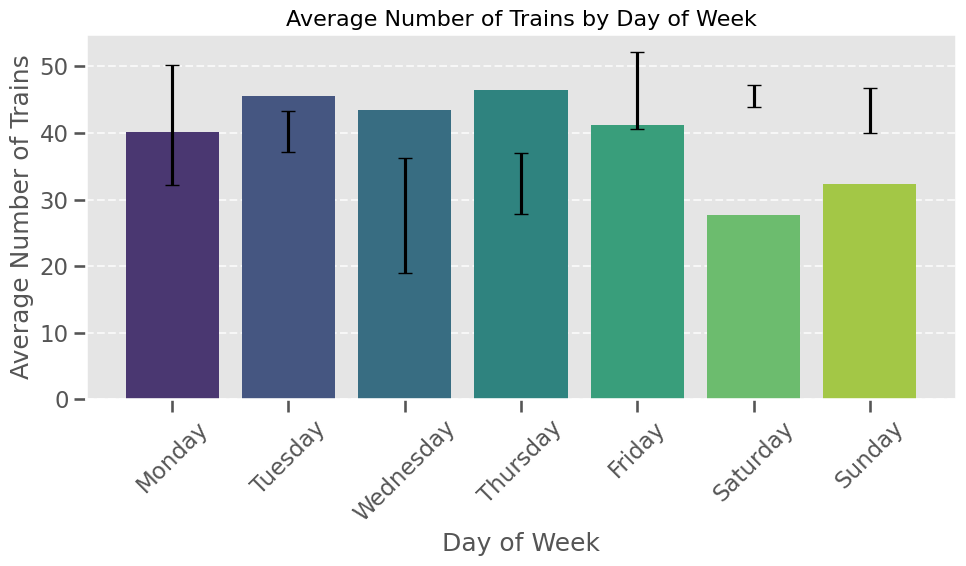

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='day_name', y='avg_trains', data=weekly_stats, order=day_order, palette='viridis')
plt.title('Average Number of Trains by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Trains')
plt.xticks(rotation=45)

# Add standard deviation
for i, row in weekly_stats.iterrows():
    ax.errorbar(i, row['avg_trains'], yerr=row['std_trains'], color='black', capsize=5)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/yz/0gcf54qd3rn9tj2bvs7f01bh0000gn/T/ipykernel_26184/1501086374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='count', data=day_data, order=day_order, palette='Set3')


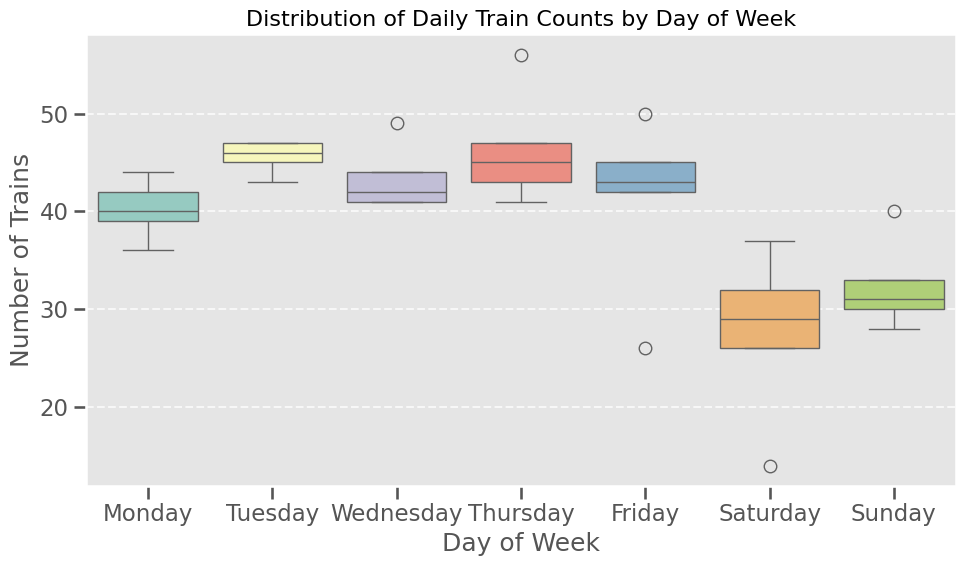

In [17]:
plt.figure(figsize=(10, 6))
day_data = df.groupby(['date', 'day_name']).size().reset_index(name='count')
sns.boxplot(x='day_name', y='count', data=day_data, order=day_order, palette='Set3')
plt.title('Distribution of Daily Train Counts by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Number of Trains')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Monthly Statistics

In [18]:
# Group by week of year
weekly_aggregated = df.groupby([df['timestamp'].dt.isocalendar().year, 
                               df['timestamp'].dt.isocalendar().week]).agg(
    total_trains=('timestamp', 'count'),
    left_to_right=('direction', lambda x: (x == 'Left to Right').sum()),
    right_to_left=('direction', lambda x: (x == 'Right to Left').sum()),
    avg_interval=('minutes_since_last_train', 'mean'),
    avg_motion=('motion_intensity', 'mean')
).reset_index()
weekly_aggregated.columns = ['year', 'week', 'total_trains', 'left_to_right', 'right_to_left', 
                           'avg_interval', 'avg_motion']

## Hourly Patterns

In [19]:
hourly_stats = df.groupby('hour').agg(
    avg_trains=('timestamp', lambda x: x.count() / df['date'].nunique()),
    std_trains=('timestamp', lambda x: x.count() / df['date'].nunique() if df['date'].nunique() > 1 else 0),
    avg_left_to_right=('direction', lambda x: (x == 'Left to Right').sum() / df['date'].nunique()),
    avg_right_to_left=('direction', lambda x: (x == 'Right to Left').sum() / df['date'].nunique()),
    avg_motion=('motion_intensity', 'mean')
).reset_index()

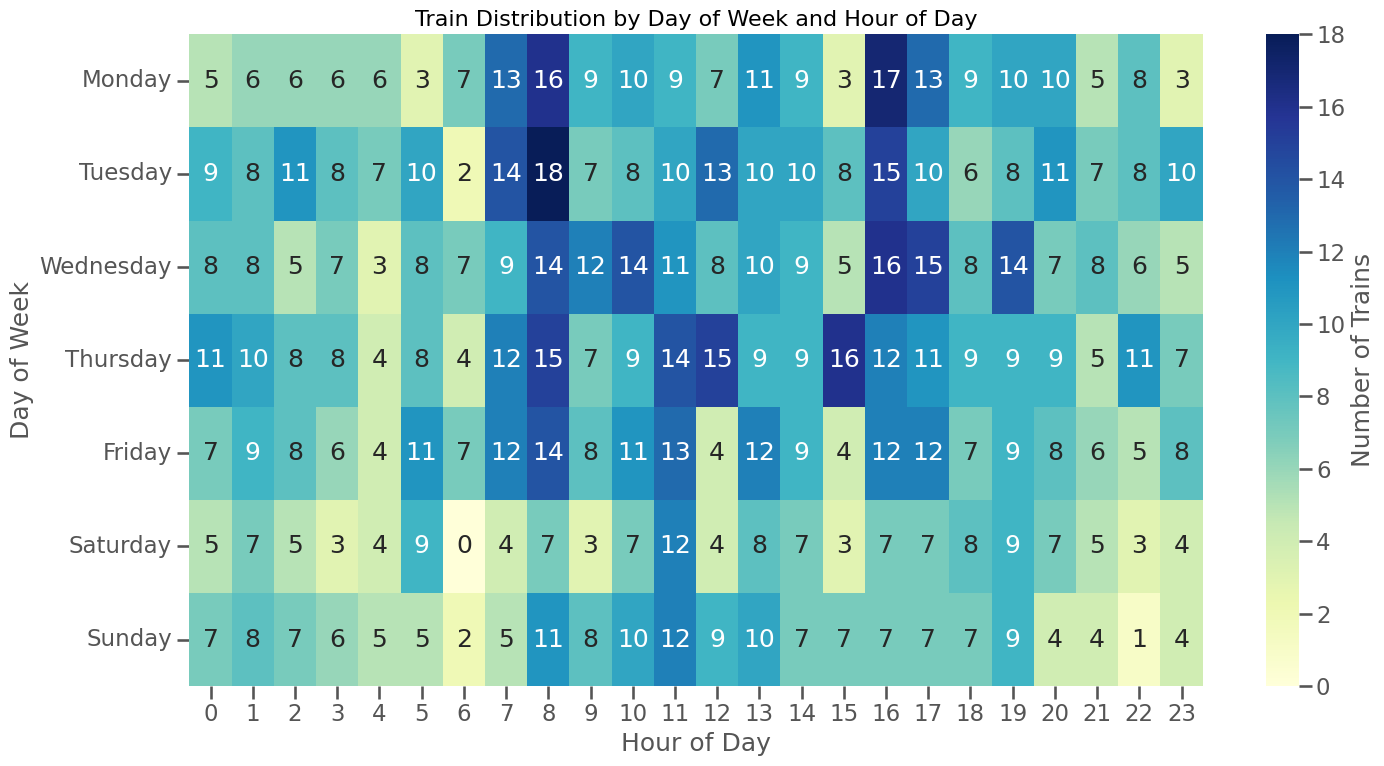

In [20]:
# Create a pivot table for the heatmap
hour_day_counts = pd.pivot_table(
    df,
    values='timestamp',
    index='day_name',
    columns='hour',
    aggfunc='count',
    fill_value=0
)

# Order by day of week
hour_day_counts = hour_day_counts.reindex(day_order)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(hour_day_counts, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Number of Trains'})
plt.title('Train Distribution by Day of Week and Hour of Day', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

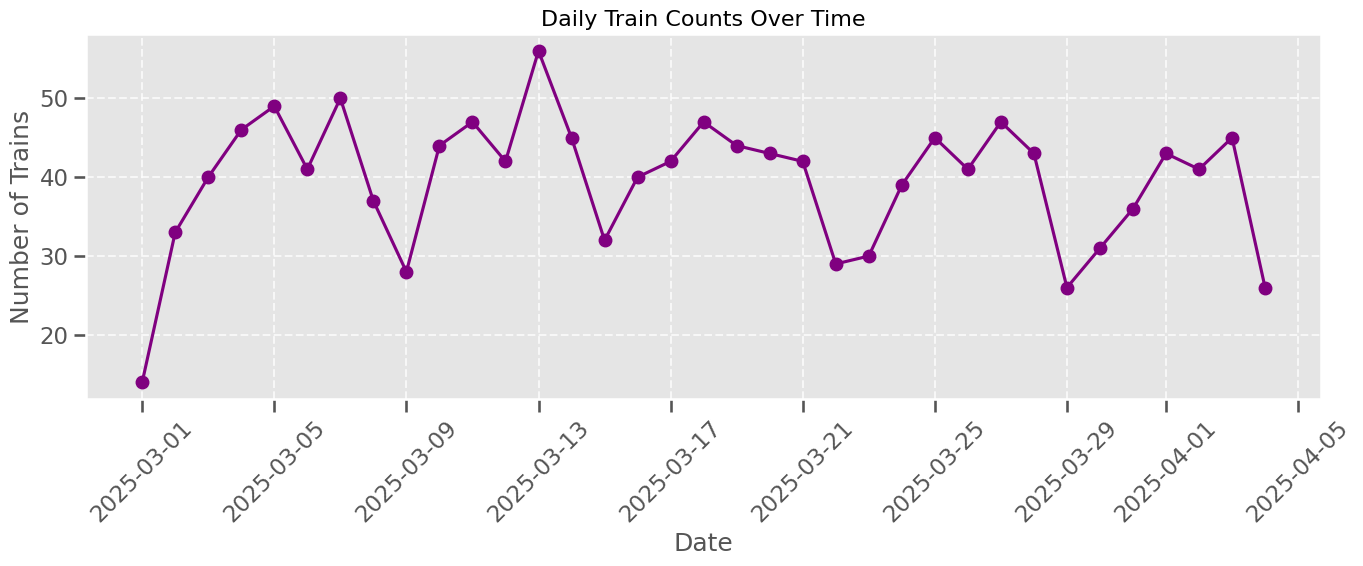

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(daily_stats['date'], daily_stats['total_trains'], marker='o', linestyle='-', color='purple')
plt.title('Daily Train Counts Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Trains')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Detailed Statistical Report and Forecasting

In [22]:
def get_mode(series):
    mode_result = stats.mode(series)
    return mode_result.mode[0] if len(mode_result.mode) > 0 else None

In [23]:
mode_stats = {
    'Most common number of daily trains': get_mode(daily_stats['total_trains']),
    'Most common left-to-right trains per day': get_mode(daily_stats['left_to_right']),
    'Most common right-to-left trains per day': get_mode(daily_stats['right_to_left']),
    'Most common hour for train activity': get_mode(df['hour']),
    'Most common day for train activity': get_mode(daily_stats['day_name']),
    'Most common direction': get_mode(df['direction'])
}
mean_stats = {
    'Mean daily trains': daily_stats['total_trains'].mean(),
    'Median daily trains': daily_stats['total_trains'].median(),
    'Mean left-to-right trains': daily_stats['left_to_right'].mean(),
    'Mean right-to-left trains': daily_stats['right_to_left'].mean(),
    'Mean interval between trains (minutes)': df['minutes_since_last_train'].mean(),
    'Median interval between trains (minutes)': df['minutes_since_last_train'].median()
}
dispersion_stats = {
    'Standard deviation of daily trains': daily_stats['total_trains'].std(),
    'Range of daily trains': daily_stats['total_trains'].max() - daily_stats['total_trains'].min(),
    'Standard deviation of train intervals': df['minutes_since_last_train'].std(),
    'Coefficient of variation for daily trains': daily_stats['total_trains'].std() / daily_stats['total_trains'].mean() if daily_stats['total_trains'].mean() > 0 else 0
}
busiest_stats = {
    'Busiest day': daily_stats.loc[daily_stats['total_trains'].idxmax(), 'date'].strftime('%Y-%m-%d'),
    'Busiest day of week': weekly_stats.loc[weekly_stats['avg_trains'].idxmax(), 'day_name'],
    'Busiest hour of day': hourly_stats.loc[hourly_stats['avg_trains'].idxmax(), 'hour'],
    'Quietest day of week': weekly_stats.loc[weekly_stats['avg_trains'].idxmin(), 'day_name'],
    'Quietest hour of day': hourly_stats.loc[hourly_stats['avg_trains'].idxmin(), 'hour']
}

/var/folders/yz/0gcf54qd3rn9tj2bvs7f01bh0000gn/T/ipykernel_26184/2704066831.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_result = stats.mode(series)
/var/folders/yz/0gcf54qd3rn9tj2bvs7f01bh0000gn/T/ipykernel_26184/2704066831.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  mode_result = stats.mode(series)


In [24]:
print("\n===== DETAILED TRAIN TRAFFIC STATISTICS =====")
print("\n----- DAILY CENTRAL TENDENCY -----")
for stat, value in mean_stats.items():
    print(f"{stat}: {value:.2f}")

print("\n----- MODE STATISTICS (MOST COMMON VALUES) -----")
for stat, value in mode_stats.items():
    print(f"{stat}: {value}")

print("\n----- DISPERSION STATISTICS -----")
for stat, value in dispersion_stats.items():
    print(f"{stat}: {value:.2f}")

print("\n----- BUSIEST AND QUIETEST PERIODS -----")
for stat, value in busiest_stats.items():
    print(f"{stat}: {value}")

print("\n----- WEEKLY PATTERNS -----")
print(weekly_stats.to_string(index=False))

print("\n----- HOURLY PATTERNS -----")
print(hourly_stats.to_string(index=False))


===== DETAILED TRAIN TRAFFIC STATISTICS =====

----- DAILY CENTRAL TENDENCY -----
Mean daily trains: 39.54
Median daily trains: 42.00
Mean left-to-right trains: 20.60
Mean right-to-left trains: 18.94
Mean interval between trains (minutes): 35.50
Median interval between trains (minutes): 26.63

----- MODE STATISTICS (MOST COMMON VALUES) -----
Most common number of daily trains: 41
Most common left-to-right trains per day: 20
Most common right-to-left trains per day: 20
Most common hour for train activity: 8
Most common day for train activity: Saturday
Most common direction: Left to Right

----- DISPERSION STATISTICS -----
Standard deviation of daily trains: 8.43
Range of daily trains: 42.00
Standard deviation of train intervals: 31.87
Coefficient of variation for daily trains: 0.21

----- BUSIEST AND QUIETEST PERIODS -----
Busiest day: 2025-03-13
Busiest day of week: Thursday
Busiest hour of day: 8
Quietest day of week: Saturday
Quietest hour of day: 6

----- WEEKLY PATTERNS -----
 day

# Prediction Intervals for Forecasting

In [25]:
def calc_prediction_interval(data, confidence=0.95):
    mean = data.mean()
    std = data.std()
    z = stats.norm.ppf((1 + confidence) / 2)
    margin = z * std / np.sqrt(len(data))
    return mean - margin, mean + margin

In [26]:
lower_pi, upper_pi = calc_prediction_interval(daily_stats['total_trains'])
print(f"\nPrediction interval for daily trains (95% confidence): [{lower_pi:.2f}, {upper_pi:.2f}]")


Prediction interval for daily trains (95% confidence): [36.75, 42.33]
